Epoch 1/500


C:\Users\rishe\AppData\Local\Temp\ipykernel_28580\1465323022.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(start=start, freq=freq, periods=periods)
c:\Users\rishe\anaconda3\envs\py311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0593
Epoch 2/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013
Epoch 3/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5324e-04
Epoch 4/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.1715e-04
Epoch 5/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.6998e-04
Epoch 6/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.0921e-04
Epoch 7/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.6888e-04
Epoch 8/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.2662e-04
Epoch 9/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.7359e-04
Epoch 10/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.9227e-04
Epoch 11/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.5372e-04
Epoch 12/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.9189e-04
Epoch 13/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.3193e-04
Epoch 14/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4113e-04
Epoch 15/500
32/32 ━━━━━━━━━━━━━━━━

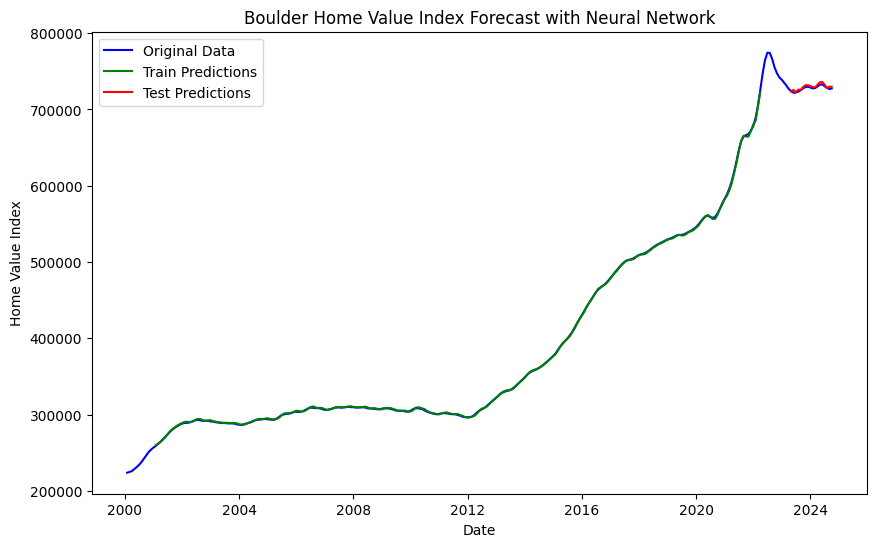


Accuracy Metrics:
MAPE: 0.26%
MAE: 1868.89


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, LSTM

def create_date_range(start='2000-01-31', end='2023-12-31', freq='M', periods=None):
    """
    Create a DatetimeIndex with enhanced flexibility.
    """
    try:
        if periods:
            date_range = pd.date_range(start=start, freq=freq, periods=periods)
        else:
            date_range = pd.date_range(start=start, end=end, freq=freq)
        return date_range
    except Exception as e:
        print(f"Error creating date range: {e}")
        return None

def prepare_data_for_nn(data, look_back=12):
    """
    Create data suitable for supervised learning for Neural Networks.
    """
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back, 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

def forecast_home_values_nn(file_path='Datasets\home_value_index_co.pkl', region='Boulder'): #
    # Read the pickle file
    df = pd.read_pickle(file_path)
    
    # Filter data for the specific region
    region_data = df[df['RegionName'] == region]['home_value_index'].values[0]
    
    # Create date range
    date_range = create_date_range(start='2000-01-31', freq='M', periods=len(region_data))
    
    # Prepare data for modeling
    df_region = pd.DataFrame({'ds': date_range, 'y': region_data})
    values = df_region['y'].values.reshape(-1, 1)
    
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(values)
    
    # Split into training and test sets
    train_size = int(len(scaled_data) * 0.9)
    train, test = scaled_data[:train_size], scaled_data[train_size:]
    
    # Create supervised learning dataset
    look_back = 12
    X_train, y_train = prepare_data_for_nn(train, look_back)
    X_test, y_test = prepare_data_for_nn(test, look_back)
    
    # Reshape input to be [samples, time steps, features] for LSTM
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    
    # Define the LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Train the model
    model.fit(X_train, y_train, epochs=500, batch_size=8, verbose=1)
    
    # Forecast future values
    predicted_train = model.predict(X_train)
    predicted_test = model.predict(X_test)
    
    # Inverse transform predictions and actual values
    predicted_train = scaler.inverse_transform(predicted_train)
    predicted_test = scaler.inverse_transform(predicted_test)
    y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(df_region['ds'], values, label='Original Data', color='blue')
    plt.plot(df_region['ds'][look_back:train_size], predicted_train, label='Train Predictions', color='green')
    plt.plot(df_region['ds'][train_size + look_back:], predicted_test, label='Test Predictions', color='red')
    plt.title(f'{region} Home Value Index Forecast with Neural Network')
    plt.xlabel('Date')
    plt.ylabel('Home Value Index')
    plt.legend()
    plt.show()
    
    # Calculate accuracy metrics
    mape = mean_absolute_percentage_error(y_test_actual, predicted_test) * 100
    mae = mean_absolute_error(y_test_actual, predicted_test)
    
    print("\nAccuracy Metrics:")
    print(f"MAPE: {mape:.2f}%")
    print(f"MAE: {mae:.2f}")
    
    return model, predicted_test, {'MAPE': mape, 'MAE': mae}

# Example usage
model, predictions, metrics = forecast_home_values_nn()
